Cleaning crime data such that:
*   Get latitude and longitude coordinates for each data point
*   Convert string representation of date and time to numerical
*   Group offenses into categories


In [1]:
# GEOPANDAS - RELATED INSTALLATIONS FOR USE IN GOOGLE COLAB
# Installations for geopandas
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (109 kB/s)
Reading package lists... Done
Building dependency tree       
Reading 

In [0]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime
from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt

In [6]:
# DOWNLOAD DATA & EVALUATE

# Download data
csv_url = 'https://opendata.arcgis.com/datasets/d1877e350fad45d192d233d2b2600156_6.csv'
# Convert string representations of data and time to timestamps (UTC time)
crime_df = pd.read_csv(csv_url, parse_dates=['DateReported'])

# Decide what to cut:
print("Available columns", crime_df.columns)
vals, counts = np.unique(crime_df['RecordID'], return_counts=True)
print("RecordID all unique values, doesn't tell anything:", np.all(counts == 1))
print("Agency is just CPD, doesn't tell us anything", np.unique(crime_df['Agency']))
vals, counts = np.unique(crime_df['IncidentID'], return_counts=True)
print("IncidentID are all unique, doesn't tell us anything", np.all(counts == 1))
print("HourReported is redundant - information already recorded in DateReported")
print("Conclusion: safe to remove RecordID, Agency, IncidentID")
# Cut unnecessary values
crime_df = crime_df.drop(columns=['RecordID', 'Agency', 'IncidentID', 'HourReported'])

Available columns Index(['RecordID', 'Offense', 'IncidentID', 'BlockNumber', 'StreetName',
       'Agency', 'DateReported', 'HourReported'],
      dtype='object')
RecordID all unique values, doesn't tell anything: True
Agency is just CPD, doesn't tell us anything ['CPD']
IncidentID are all unique, doesn't tell us anything True
HourReported is redundant - information already recorded in DateReported
Conclusion: safe to remove RecordID, Agency, IncidentID


In [0]:
# PREPROCESSING

# Generate address of crime
crime_df['BlockString'] = crime_df['BlockNumber'].apply(lambda x: '' if np.isnan(x) else int(x))
crime_df['Address'] = crime_df['BlockString'].astype(str)+' '+crime_df['StreetName']+', Charlottesville VA'
crime_df.to_csv('addresses.csv', columns=['Address'])

# Creates numpy array with crimes and associated frequencies
crime_list, crime_count = np.unique(crime_df['Offense'], return_counts = True)
crime_list = np.array(list(zip(crime_list, crime_count)))
crime_list = np.array(sorted(crime_list, key = lambda x: float(x[1]), reverse = True))

# Given a list of possible types of offenses, returns dataframe only containing rows with the offense
# case insensitive
# crime_name - name of type of crime
# df - dataframe with crime
def select_crime(crime_name, df = crime_df):
  selected_df = df[df['Offense'].str.contains(crime_name, case=False)] 
  return selected_df

# Create a dataframe that sorts based on the offenses
crime_dict = dict((crime, select_crime(crime)) for crime in crime_list[:,0])
grouped_crime_df = pd.concat(crime_dict)
grouped_crime_df = grouped_crime_df.drop(columns=['BlockNumber', 'BlockString'])

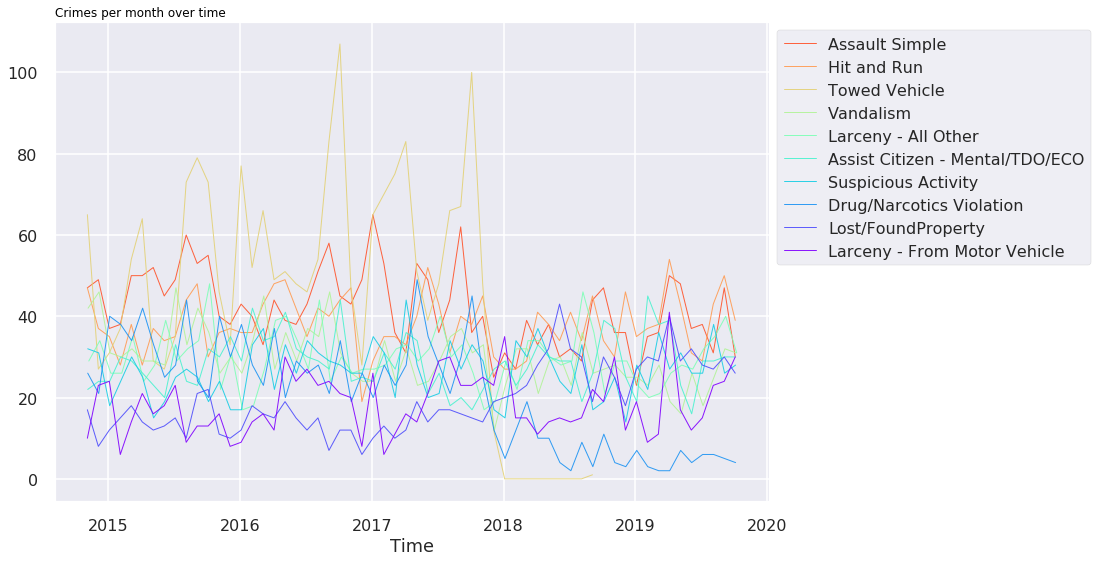

In [13]:
# PLOT
# Numbers to use as references for plotting over time
time_dict = {"day" : 1440, "week" : 10080, "month" : 43829, "year": 525600}

# Generate a plot depending on the time frame
# time - dictionary key indicating unit of time to bin by
# crimes_to_plot - dataframe grouped by type of crime
def plot_by_time(time, crimes_to_plot = crime_list[0:10,0]):
  time_offset = pd.offsets.Minute(time_dict[time])
  # style
  plt.style.use('seaborn-poster')
  # create a color palette
  palette = plt.get_cmap('rainbow')
  # multiple line plot
  num = 0.99
  for crime in crimes_to_plot:
    num = num - 0.99 / crimes_to_plot.size
    plt.plot(grouped_crime_df.loc[crime].resample(time_offset, on='DateReported')['Offense'].count(), 
            marker='', color=palette(num), linewidth=1, alpha=0.9, label=crime)
  # Add legend
  plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', ncol=1)
  # Add titles
  plt.title("Crimes per " + time + " over time", loc='left', fontsize=12, fontweight=0, color='black')
  plt.xlabel("Time")

# plot top 10 most frequent
plot_by_time('month')

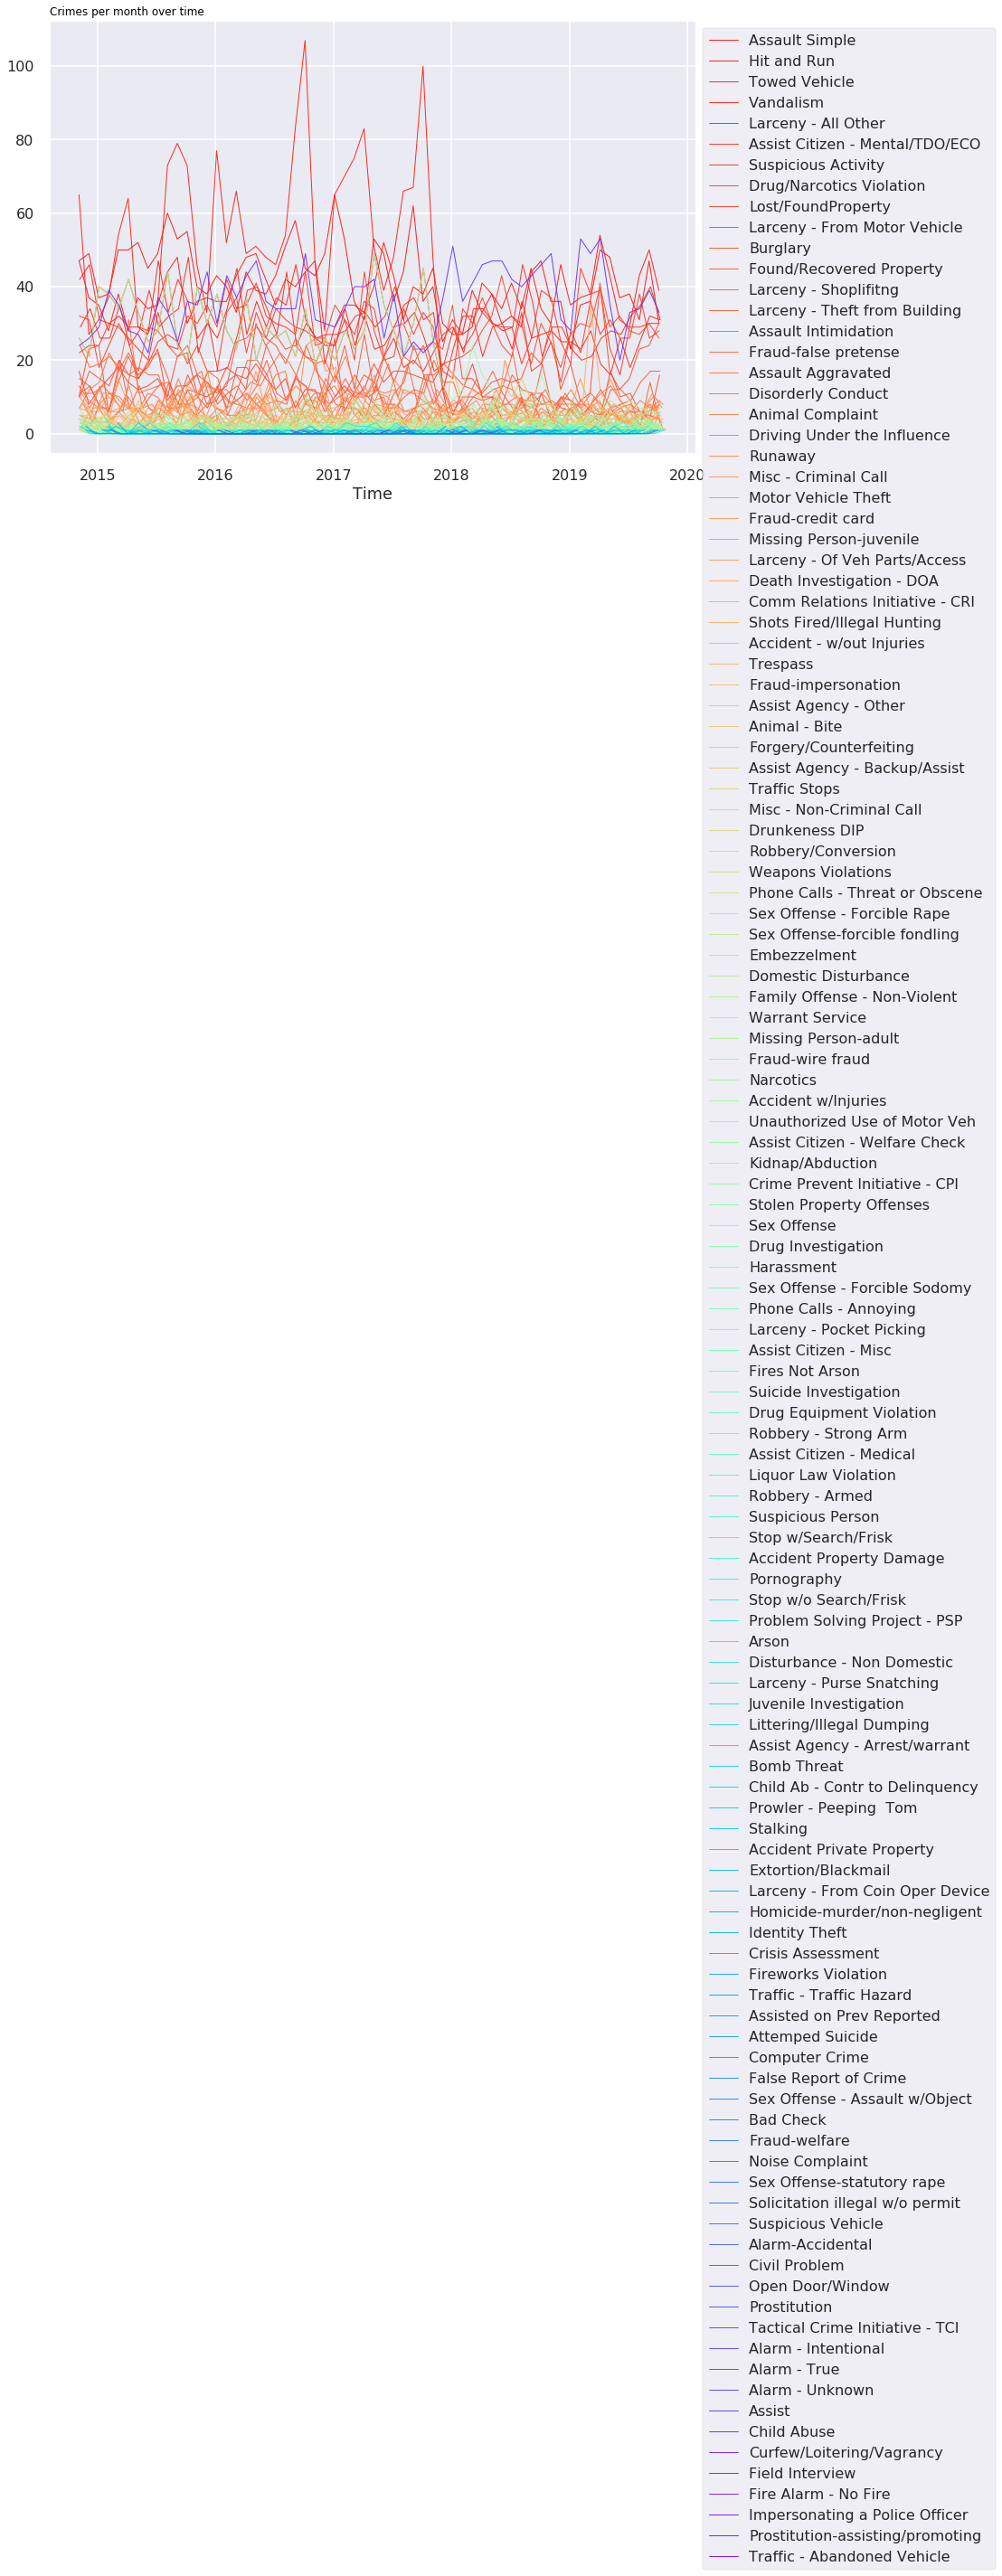

In [14]:
# plot all
plot_by_time('month', crime_list[:,0])